## Topic modelling  : Tag suggestion 

The project consists is to automatically tag stack overflow posts. 

When users write a question it can be beneficial for them and for other users to tag the topic into questions. 

Dataset : the data was optain by the following SQL query on StackExchange Data Explorer  below :   

SELECT TOP 500000 Id, PostTypeId, CreationDate, Title, Body, Tags, Score,

ViewCount, AnswerCount, CommentCount, FavoriteCount FROM Posts 

WHERE  PostTypeId = 1 AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5 

AND ViewCount > 10 AND CommentCount > 2 

AND AnswerCount > 1 AND Score > 5

In this notebook we will analyse and explore the query output and generate a clean corpus of text with te corresponding tags for further study and model selection. 

In [84]:
# Test if notebook running on google colab : 
try :
    from google.colab import drive
    drive.mount('/content/drive')
    output_dir = "/content/drive/MyDrive/OpenClassroom/"
    pathToDataSet = output_dir + "QueryResults500000.csv"
    IN_COLAB = True
except :
    IN_COLAB = False
    pathToDataSet = "C:\dev\data\QueryResults.csv"
    output_dir = "./output/"

    

In [69]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.dates
import seaborn as sns 
import re 
import tqdm

from datetime import datetime
import nltk
from nltk.stem import 	WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.core.display import display, HTML

C:\Users\clara\AppData\Local\Temp\ipykernel_27344\2292019611.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [38]:
data = pd.read_csv(pathToDataSet)
df = data 

In [39]:
df.shape

(50000, 11)

In [40]:
df.head(2)

,Id,PostTypeId,CreationDate,Title,Body,Tags,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount
0,20954805,1,2014-01-06 16:42:42,NLTK - Automatically translating similar words,<p><strong>Big picture goal:</strong> I am mak...,<python><algorithm><nltk><wordnet><gensim>,7,2698,2,3,0.0
1,2131740,1,2010-01-25 10:57:54,Online JSONP converter/wrapper,<p>I would like to fetch a source of file and ...,<web-services><json><cross-domain><jsonp><xss>,6,4835,4,4,0.0


In [41]:
df.dtypes

Id                 int64
PostTypeId         int64
CreationDate      object
Title             object
Body              object
Tags              object
Score              int64
ViewCount          int64
AnswerCount        int64
CommentCount       int64
FavoriteCount    float64
dtype: object

In [42]:
df.isna().sum()

Id                  0
PostTypeId          0
CreationDate        0
Title               0
Body                0
Tags                0
Score               0
ViewCount           0
AnswerCount         0
CommentCount        0
FavoriteCount    5884
dtype: int64

In [43]:
df.drop(columns=["FavoriteCount"],inplace=True)

# Univariate analysis : CreationDate 

In [44]:
df["CreationDate"] = pd.to_datetime(df["CreationDate"])
print(" First post of in dataframe : ", np.min( df["CreationDate"] ))
print(" Last post of in dataframe : ", np.max( df["CreationDate"] ))


 First post of in dataframe :  2008-07-31 21:42:52
 Last post of in dataframe :  2023-06-21 21:12:39


Post are from 2008, which is actually the creation of the website to 2023. 

## Bi-variate and multivariate analysis : Scores and creation year 


the first assumption would be that the older a post is, the best score it has; let's verify that : 


In [45]:
# Compute median of saturated-fat_100g for each fat quantiles 
df["CreationYear"] = df["CreationDate"].dt.year
groups = df.groupby('CreationYear')["Score"]
des = groups.describe()

des[["mean","std","75%"]].head()

,mean,std,75%
CreationYear,,,
2008,472.465784,1032.743231,408.0
2009,150.523590,747.362998,74.0
2010,76.605827,440.357798,37.0
2011,45.389172,160.618304,28.0
2012,39.823861,383.348806,24.0


Clearly, the older the post is the most high score ouliers exist. Indeed, the mean is higher than the median and the standard deviation is high. 

Let's look at the different scores and correlation between them : 

In [46]:
scores = ["Score",	"ViewCount"	,"AnswerCount",	"CommentCount"]
df[scores].describe()


,Score,ViewCount,AnswerCount,CommentCount
count,50000.000000,5.000000e+04,50000.000000,50000.000000
mean,41.969220,3.972398e+04,4.697220,5.877800
std,266.308615,1.712104e+05,4.774193,3.743024
min,6.000000,8.400000e+01,2.000000,3.000000
25%,8.000000,3.308000e+03,2.000000,3.000000
50%,12.000000,9.294500e+03,3.000000,5.000000
75%,24.000000,2.675050e+04,5.000000,7.000000
max,27014.000000,1.285623e+07,134.000000,71.000000


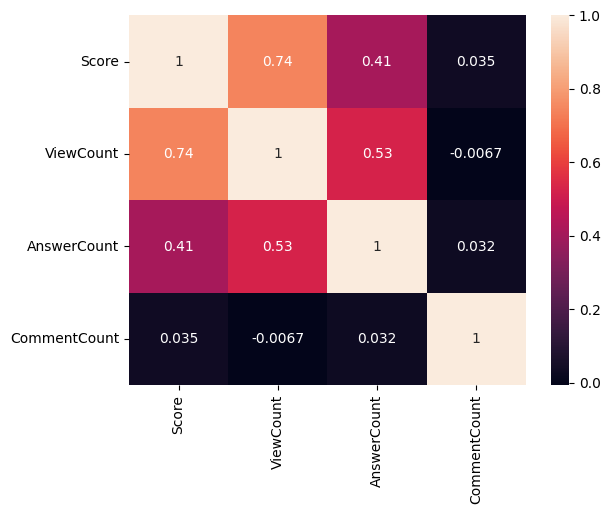

In [47]:
sns.heatmap(df[scores].corr(), annot=True)
plt.show()

The correlation is very low between the commentCount and the other scores. What is interesting is that there is a high correlation between the viewCount and the score, meaning that the more a post is seen, the higher score it get. 

# Tags 

Now we want to explore the tag by post, first we need to extract them trough a regex : 

In [48]:

def processTags(tags) : 
    # use regex to extract tags to list 
    regex = '<([^>]+)>'
    tagslist = re.split(regex, tags)
    # filter None values 
    tagslist_clean = filter(None, tagslist)
    # all tags to lower case 
    tagslist_lower = [ str(x).lower() for x in tagslist_clean ] 
    return tagslist_lower



In [49]:
df["tag_list"] = df["Tags"].apply(processTags)

In [50]:

tag_count = df["tag_list"].explode().value_counts()

In [51]:
len(tag_count) # number of unique tags 

17160

In [52]:
tag_count.head(10)

tag_list
c#            6477
java          6287
c++           5629
javascript    5402
python        4552
ios           3528
android       3528
.net          2896
c             2560
html          2492
Name: count, dtype: int64

actually most tag counts are equal to 5 

In [53]:
tag_count.tail(10)

tag_list
notifydatasetchanged         1
watchdog                     1
double-free                  1
request-cancelling           1
clcircleregion               1
css-to-pdf                   1
activitynotfoundexception    1
weld2                        1
pmap                         1
ibm-blockchain               1
Name: count, dtype: int64

In [54]:
number_of_different_tags  = df["tag_list"].explode().unique().shape[0]
print(number_of_different_tags)

17160


There are 17148 different tags in the datasets, this is a lot for tag suggestion. So we will only keep tags in the third quartile (appearing 6 times or more)

In [55]:
Q3_tag_count = np.quantile(tag_count, 0.75)
tag_list_to_keep = tag_count[tag_count > Q3_tag_count ].index
print(tag_list_to_keep.shape[0])
print(tag_list_to_keep.shape[0]/number_of_different_tags *100)

3983
23.210955710955712


Here we only select 3971 tags over the 1748, so around **25%**. 

In [56]:
def keep_most_used_tags(tag_list): 
    tag_list = [ str(tag)  for tag in tag_list   if tag in tag_list_to_keep]
    return tag_list

In [57]:
df["tag_list_clean"] = df["tag_list"].apply(keep_most_used_tags)

In [58]:
df[["tag_list","tag_list_clean"]].head()

,tag_list,tag_list_clean
0,"[python, algorithm, nltk, wordnet, gensim]","[python, algorithm, nltk]"
1,"[web-services, json, cross-domain, jsonp, xss]","[web-services, json, cross-domain, jsonp, xss]"
2,"[ruby-on-rails, ruby, testing, factory-bot, ma...","[ruby-on-rails, ruby, testing]"
3,"[ruby-on-rails, ruby, memory, memory-leaks, ru...","[ruby-on-rails, ruby, memory, memory-leaks]"
4,"[c, arrays, pointers, dereference, operator-pr...","[c, arrays, pointers, dereference, operator-pr..."


Here is a subset example, nswindowcontrol was not kept. 

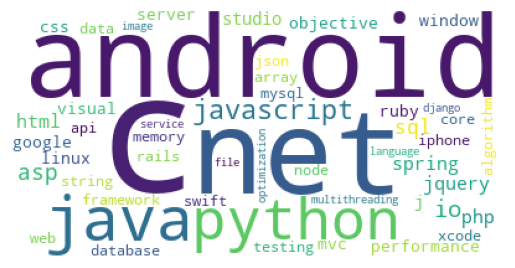

In [59]:
text = ' '.join(tuple(df["tag_list"].explode()))

#create the wordcloud object
wordcloud = WordCloud(collocations = False,
                      background_color = 'white',
                      max_words=50).generate(text)
                    #   font_path=r"C:\Users\Clara\Documents\dev\machine_learning\cours\NLP\GothamMedium.ttf"
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

The idea is also that tag link to the same post have common semantics. How to use  that ???? 

## Length of post  : 
remove interquartile outliers 

This post is very short, for better lets analyse the length of posts : 

In [60]:


def returnRawTextTromHTML(htmltext): 
    soup = BeautifulSoup(htmltext, 'html.parser')
    soup_str = soup.get_text()
    return soup_str

def lengthOfDoc(doc) : 
    return len(doc.split())


In [61]:
df["Title_str"] = df["Title"].apply(returnRawTextTromHTML)

C:\Users\clara\AppData\Local\Temp\ipykernel_27344\223150988.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(htmltext, 'html.parser')


In [62]:
df["Body_str"] = df["Body"].apply(returnRawTextTromHTML)

In [63]:
df["posts_length"] = df["Body_str"].apply(lengthOfDoc)

In [64]:
df["posts_length"].describe()

count    50000.000000
mean       216.269880
std        220.073316
min          6.000000
25%         93.000000
50%        155.000000
75%        262.000000
max      10725.000000
Name: posts_length, dtype: float64

In [65]:
# Remove outliers
def drop_interquartile_outliers(column, dataFrame):
    Q3 = np.quantile(column, 0.75)
    Q1 = np.quantile(column, 0.25)
    IQR = Q3 - Q1
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    mask = (column < lower_range) | (column > upper_range)
    dataFrame.drop(column.loc[mask].index, inplace=True)

Only keep post of more than 100 words : 

In [66]:
mask = df["posts_length"] < 100 
df.drop(df.loc[mask].index, inplace=True)

# View first post : 

In [70]:

title = df.iloc[0][["Title"]][0]
bodyPost = df.iloc[0][["Body"]][0]
tags = df.iloc[0][["Tags"]][0]


tag_of_post = processTags(tags)


print("Title : ")
display(HTML(title))
print("Posts : ")
display(HTML(bodyPost))
print("Tags : ",' '.join(tag_of_post))


Title : 


Posts : 


Tags :  python algorithm nltk wordnet gensim


# Handling HTML 

In [71]:
body_str = returnRawTextTromHTML(bodyPost)

## Create dictionnary of the corpus 

In [72]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
englishstopwords = stopwords.words('english')

def tokenize_stopwords_and_short_words_handling(tokens, body) : 
    for token in nltk.word_tokenize(body) : 
        if token not in englishstopwords and len(token) > 3 : 
            word = lemmatizer.lemmatize(token)
            tokens.append(word)
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\clara\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\clara\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\clara\AppData\Roaming\nltk_data...


In [73]:
dic = ' '.join(df["Body_str"])

In [74]:
tokens = []
lemmatizer = WordNetLemmatizer()
for body in df["Body_str"] : 
    tokens = tokenize_stopwords_and_short_words_handling(tokens, body)


In [75]:
len(tokens)

5571737

In [76]:
token_series = pd.Series(tokens)
token_series = token_series[token_series.duplicated(keep=False)]
most_used_words_100 = token_series.value_counts().head(100).index

In [77]:
most_used_words_100

Index(['using', 'public', 'code', 'return', 'file', 'class', 'like',
       'function', 'error', 'work', 'would', 'data', 'http', 'value', 'This',
       'void', 'problem', 'android', 'import', 'want', 'time', 'type',
       'string', 'need', 'method', 'user', 'following', 'object', 'true',
       'line', 'name', 'String', 'result', 'version', 'tried', 'test',
       'application', 'know', 'also', 'question', 'private', 'make', 'example',
       'call', 'could', 'null', 'trying', 'project', 'server', 'case', 'image',
       'something', 'solution', 'const', 'found', 'static', 'false', 'Here',
       'issue', 'request', 'What', 'used', 'find', 'first', 'array', 'page',
       'else', 'class=', 'name=', 'change', 'working', 'main', 'seems', 'list',
       'text', 'message', 'different', 'number', 'help', 'still', 'When',
       'look', 'table', 'create', 'However', 'include', 'input', 'view',
       'thread', 'without', 'output', 'point', 'running', 'library', 'even',
       'property', 

# remove most used words

In [78]:
token_series

0            picture
1               goal
2             making
3              model
4            product
             ...    
5571732       honest
5571733         What
5571734       option
5571735    available
5571736       Thanks
Length: 5191893, dtype: object

In [79]:
list = token_series.index.to_list()
len(list)

5191893

In [80]:
token_series.values.shape

(5191893,)

In [81]:
token_series.isin(most_used_words_100)

0          False
1          False
2          False
3          False
4          False
           ...  
5571732    False
5571733     True
5571734     True
5571735    False
5571736    False
Length: 5191893, dtype: bool

In [82]:
token_list = token_series.values
token_series_clean = token_series[ ~token_series.isin(most_used_words_100) ]


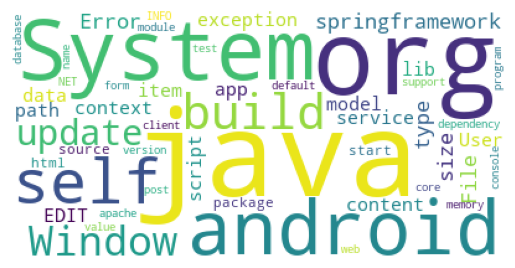

In [85]:
text = ' '.join(tuple(token_series_clean.values))

#create the wordcloud object
wordcloud = WordCloud(collocations = False,
                      background_color = 'white',
                      max_words=50).generate(text)
                    #   font_path=r"C:\Users\Clara\Documents\dev\machine_learning\cours\NLP\GothamMedium.ttf"
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [86]:
# Save words dictionary of the entire corpus : 
np.save(output_dir + "token_series_clean.npy", token_series_clean.values, allow_pickle=True)

# corpus creation : 

In [87]:
def tokenize_stopwords_and_short_words_most_used_handling(input_string,  list_non_selected_tokens, pattern1 , pattern2) : 
    tokens = []
    for token in nltk.word_tokenize(input_string) : 
      if  len(token) > 3 : 
        if token not in list_non_selected_tokens : 
          if not pattern1.match(token) and not pattern2.match(token): 
              word = lemmatizer.lemmatize(token)
              tokens.append(word)
    return tokens

In [88]:
regex1 = "^.*\/[^\/]+" 
pattern1 = re.compile(regex1)
regex2 = "([^-]*-+[^-]+)+"
pattern2 = re.compile(regex2)
urls = ['http', 'https']
list_non_selected_words = np.concatenate((englishstopwords , most_used_words_100, urls))

def mysem(input_string) : 
  return tokenize_stopwords_and_short_words_most_used_handling(input_string, list_non_selected_words, pattern1, pattern2)

In [89]:

print(df[["Title_str"]].iloc[0].values[0])
print(mysem(df[["Title_str"]].iloc[0].values[0]))

NLTK - Automatically translating similar words
['NLTK', 'Automatically', 'translating', 'similar', 'word']


In [90]:
test = "https://stackoverflow.com/questions/72596413/how-to-obtain-sentencetransformer-vocab-from-corpus-or-query"
print(mysem(test))
test2 = "how-to-obtain-sentencetransformer-vocab-from-corpus-or-query"  
print(mysem(test2))                                                      

[]
[]


In [91]:

corpus = [] 
titles = []
tags = []
pbar = tqdm.tqdm(total=df.shape[0])
for index, row in df.iterrows():
    
    tokens = mysem(row["Body_str"])
    
    tokens_title = mysem(row["Title_str"])
    
    corpus.append(tokens)
    titles.append(tokens_title)
    tags.append(row["tag_list_clean"])
    
    pbar.update(1)
    
pbar.close()


NameError: name 'tqdm' is not defined

In [ ]:
np.save(output_dir + "corpus.npy"       ,corpus, allow_pickle=True)
np.save(output_dir + "corpus_tags.npy" ,tags,   allow_pickle=True)
np.save(output_dir + "titles.npy"      ,titles, allow_pickle=True)

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
